In [1]:
import mdtraj as md
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
from plotly.subplots import make_subplots
import math
import seaborn as sns
from tqdm import tqdm

In [5]:
def clean_xyz_file(input_file: str, output_file: str):
    """
    Cleans an XYZ file by removing non-numeric header lines from MDAnalysis.
    Ensures the first line is a valid number (atom count) for mdtraj.
    """
    with open(input_file, "r") as infile, open(output_file, "w") as outfile:
        for line in infile:
            stripped = line.strip()
            # ✅ Keep only numeric lines or valid XYZ format (skip MDAnalysis headers)
            if stripped and (stripped[0].isdigit() or "H" in stripped or "O" in stripped or "Li" in stripped):
                outfile.write(line + "\n")


clean_xyz_file('/media/turcinv/BACKUP/10diel_20Li_64H2O/traj.ALL.fixed.xyz', '/media/turcinv/BACKUP/10diel_20Li_64H2O/trj_001/clean.xyz')

In [10]:
traj = md.load('/media/turcinv/BACKUP/10diel_20Li_64H2O/traj.ALL.fixed.xyz', top='/media/turcinv/BACKUP/10diel_20Li_64H2O/top.pdb')

In [3]:
fp = '/data/work/Water_reactivity/prod-GGA-vasp/'

### FUCNTIONS

In [4]:
def check_OH_dissociation(trajectory_file, topology_file, box_size, threshold=2.0):
    """
    Analyzes a molecular dynamics trajectory to detect dissociation and reassociation of O-H bonds in water molecules based on O-H bonds being above a certain threshold.
    
    Parameters:
    - trajectory_file (str): Path to the trajectory file in XYZ format.
    - topology_file (str): Path to the topology file.
    - box_size (float): The simulation box size in Angstroms.
    - threshold (float): Distance threshold in Angstroms for considering an O-H bond dissociated.
    """
    # Load the trajectory and topology
    traj = md.load(trajectory_file, top=topology_file)
    traj.unitcell_lengths = np.ones((len(traj), 3)) * (box_size / 10)  # Convert box size to nm
    traj.unitcell_angles = np.ones((len(traj), 3)) * 90

    topol = traj.topology
    Hs = topol.select('element H')
    Os = topol.select('element O')
    
    # Create OH pairs such that each oxygen pairs with its two corresponding hydrogens
    OH_pairs = []
    for o in Os:
        # Find the index range for hydrogens corresponding to this oxygen
        # Each water molecule: H1, H2, O
        hydrogen_start_index = 2 * (o - Os[0])  # Since there are two Hs for every O
        OH_pairs.append((Hs[hydrogen_start_index], o))
        OH_pairs.append((Hs[hydrogen_start_index + 1], o))

    
 # Initialize count of dissociated bonds
    dissociated_count = 0

    # Process each OH bond
    for index, (h, o) in enumerate(OH_pairs):
        bond_label = f'Bond {index + 1} (H: {h}, O: {o})'
        distances = md.compute_distances(traj, [[h, o]], opt=True, periodic=True)[:, 0]  # distances are in nm
        dissociated = np.any(distances > (threshold / 10))  # Convert threshold to nm
        if dissociated:
            dissociated_count += 1
            first_dissociation_frame = np.argmax(distances > (threshold / 10))
            print(f"{bond_label} dissociated at {np.round(first_dissociation_frame / 2000, 2)} ps")

    # Output total number of dissociated bonds
    print(f"Total number of dissociated bonds: {dissociated_count}")


In [5]:
def find_HH_distances(trajectory_file, topology_file, box_size, threshold=1.2, plot=True):
    """
    Analyzes a molecular dynamics trajectory to monitor all H-H distances 
    that indicate potential molecular hydrogen formation.
    plot=True plots the evolution of H- distances that potentially lead to molecular hydrogen formation.
    
    - trajectory_file (str): Path to the trajectory file in XYZ format.
    - topology_file (str): Path to the topology file.
    - box_size (float): The simulation box size in Ångströms.
    - threshold (float): Distance threshold in Angstroms for potential bonding.
    - plot (bool): If True, plots the H-H distances; if False, returns the DataFrame.
    """
    
    traj = md.load(trajectory_file, top=topology_file)
    traj.unitcell_lengths = np.ones((len(traj), 3)) * (box_size / 10)  # Box size in nm
    traj.unitcell_angles = np.ones((len(traj), 3)) * 90

    # Select all hydrogen atoms
    Hs = traj.topology.select('element H')
    H_pairs = traj.topology.select_pairs(Hs, Hs)

    # Convert threshold to nanometers
    threshold_nm = threshold / 10

    # Array to store distances for pairs that ever go below the threshold
    potential_h2_pairs = []
    potential_h2_distances = []

    # Calculate distances across all frames
    all_distances = md.compute_distances(traj, H_pairs, opt=True, periodic=True)

    # Filter pairs that ever go below the threshold
    min_distances = all_distances.min(axis=0)
    bonded_pairs = H_pairs[min_distances < threshold_nm]

    print(f"{len(bonded_pairs)} potential molecular hydrogens detected.")

    # Create a dictionary with pair information and corresponding distances
    distance_dict = {f'Pair {i+1} (H{pair[0]}-H{pair[1]})': all_distances[:, idx]
                     for i, pair in enumerate(bonded_pairs)
                     for idx in np.where((H_pairs == pair).all(axis=1))[0]}

    distances_df = pd.DataFrame(distance_dict)

    if plot and not distances_df.empty:
        # Plotting directly from DataFrame
        fig, ax = plt.subplots(figsize=(9, 4))

        for col in distances_df.columns:
            ax.plot(distances_df.index / 2000, distances_df[col]*10, label=col, lw=1)

        ax.set_xlabel('Time [ps]', fontsize=12)
        ax.set_ylabel('Distance [Å]', fontsize=12)
        ax.set_title('H-H Distances Over Time', fontsize=14)
        ax.set_ylim(0.5, 6)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), title='H-H Pairs')
        ax.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        return distances_df

In [6]:
def track_molecular_hydrogen(trajectory_file, topology_file, box_size, threshold=1.2, write_indicies=True, output_indices='indices.txt'):
    """
    Tracks the formation and persistence of molecular hydrogen in a molecular dynamics simulation based on the H-H distance being below a certain threshold.
    write_indicies can save indices of H atoms forming the molecular hydrogen in a text file for visualization.
    
    Parameters:
    - trajectory_file (str): Path to the XYZ trajectory file.
    - topology_file (str): Path to the topology file.
    - box_size (float): Size of the simulation box in Ångströms.
    - threshold (float): Distance threshold in Ångströms for H-H bonding (default is 1.2 Å).
    
    Returns:
    - A list of frames where molecular hydrogen was first formed and persisted until the end of the trajectory.
    """

    traj = md.load(trajectory_file, top=topology_file)
    traj.unitcell_lengths = np.ones((len(traj), 3)) * (box_size / 10)  # Box size in nm
    traj.unitcell_angles = np.ones((len(traj), 3)) * 90

    Hs = traj.topology.select('element H')
    H_pairs = traj.topology.select_pairs(Hs, Hs)

    threshold_nm = threshold / 10  # Convert threshold to nanometers

    all_distances = md.compute_distances(traj, H_pairs, opt=True, periodic=True)

    # Identifying pairs that form and then remain formed
    persistent_formations = []
    persistent_count = 0

    # Check each pair for persistent formation from any frame till the end
    for idx, pair_distances in enumerate(all_distances.T):  # Transpose to iterate over pairs
        stable_start_indices = np.where(pair_distances < threshold_nm)[0]
        
        # Check if there's any segment from some index till the end that's below threshold
        for start_idx in stable_start_indices:
            if (pair_distances[start_idx:] < threshold_nm).all():
                persistent_formations.append((H_pairs[idx], start_idx))
                persistent_count += 1
                print(f"Hydrogen pair {H_pairs[idx]} formed molecular hydrogen persistently from {np.round(start_idx / 2000, 2)} ps")
                break  # Stop after the first persistent segment is found for this pair

    
    
    if write_indicies:
        hydrogen_indices = [index for pair, _ in persistent_formations for index in pair]    
        with open(output_indicies, 'w') as f:
            f.write(' '.join(map(str, hydrogen_indices)))

    print(f"Total persistent molecular hydrogen formations: {persistent_count}")


In [7]:
def save_reaction_times(trajectory_file, topology_file, box_size, threshold=1.2):
    traj = md.load(trajectory_file, top=topology_file)
    traj.unitcell_lengths = np.ones((len(traj), 3)) * (box_size / 10)  # Box size in nm
    traj.unitcell_angles = np.ones((len(traj), 3)) * 90

    Hs = traj.topology.select('element H')
    H_pairs = traj.topology.select_pairs(Hs, Hs)
    threshold_nm = threshold / 10  # Convert threshold to nanometers
    all_distances = md.compute_distances(traj, H_pairs, opt=True, periodic=True)

    reaction_times = []

    # Check each pair for persistent formation from any frame till the end
    for idx, pair_distances in enumerate(all_distances.T):  # Transpose to iterate over pairs
        stable_start_indices = np.where(pair_distances < threshold_nm)[0]
        for start_idx in stable_start_indices:
            if (pair_distances[start_idx:] < threshold_nm).all():
                reaction_time_ps = np.round(start_idx / 2000, 2)
                reaction_times.append(reaction_time_ps)
                break  # Stop after the first persistent segment is found for this pair

    reaction_times.sort()
    return reaction_times



### Writing reaction times for 10 dielectrons

In [ ]:
# Collecting and writing to CSV
topology_file = fp + '10diel_20Li_64H2O/top.pdb' 
box_size = 13.390
output_file = '10_diel_reaction_times.csv'
reaction_times_data = {}

for i in tqdm(range(1, 50), desc='Analyzing Trajectories', ncols=80):
    folder_name = f"trj_{i:03}"
    trajectory_file = f'{fp}10diel_20Li_64H2O/{folder_name}/traj.ALL.xyz'
    reaction_times = save_reaction_times(trajectory_file, topology_file, box_size)
    reaction_times_data[f'{i}'] = reaction_times

# Creating a DataFrame and writing to a CSV
reaction_times_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in reaction_times_data.items()]))
reaction_times_df.to_csv(output_file, index=False)

Analyzing Trajectories:   0%|                            | 0/49 [00:00<?, ?it/s]/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:204: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(
Analyzing Trajectories:  22%|████▎              | 11/49 [03:00<10:04, 15.90s/it]

### Writing reaction times for 01 dielectrons

In [8]:
# Collecting and writing to CSV
topology_file = fp + '01diel_02Li_64H2O/top.pdb' 
box_size = 12.530
output_file = '01_diel_reaction_times.csv'
reaction_times_data = {}

for i in tqdm(range(1, 51), desc='Analyzing Trajectories', ncols=80):
    folder_name = f"trj_{i:03}"
    trajectory_file = f'{fp}01diel_02Li_64H2O/{folder_name}/traj.ALL.xyz'
    reaction_times = save_reaction_times(trajectory_file, topology_file, box_size)
    reaction_times_data[f'{i}'] = reaction_times

# Creating a DataFrame and writing to a CSV
reaction_times_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in reaction_times_data.items()]))
reaction_times_df.to_csv(output_file, index=False)

Analyzing Trajectories: 100%|███████████████████| 50/50 [05:27<00:00,  6.56s/it]


### Graphs of reaction times

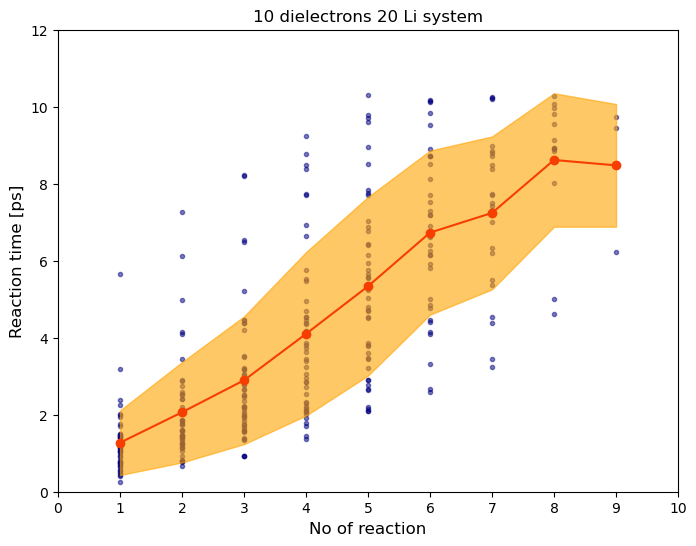

In [76]:
df = pd.read_csv('10_diel_reaction_times.csv')

data = []

plt.figure(figsize=(8, 6))

for i in range(9):
    plt.scatter(np.ones(len(df.T[i]))* (i + 1) , df.T[i], marker='.', color = 'navy', alpha=0.5)

    mean_val = np.mean(df.T[i])
    sem_val = np.std(df.T[i])  
    data.append([i + 1, mean_val, sem_val])

reaction_stats_df = pd.DataFrame(data, columns=['Number', 'Mean', 'Error'])

plt.plot(reaction_stats_df['Number'], reaction_stats_df['Mean'], color='#f63e02', marker='o')
plt.fill_between(reaction_stats_df['Number'], reaction_stats_df['Mean'] - reaction_stats_df['Error'], reaction_stats_df['Mean'] + reaction_stats_df['Error'], color='#FFA400', alpha=0.6)


plt.xlim(0, 10)
plt.ylim(0, 12)
plt.xticks(np.arange(0, 10.1, 1))
plt.xlabel('No of reaction',fontsize=12)
plt.ylabel('Reaction time [ps]',fontsize=12)
plt.title('10 dielectrons 20 Li system')
# plt.grid()
plt.show()


In [70]:
reaction_stats_df

,Number,Mean,Error
0,1,1.273200,0.839751
1,2,2.064000,1.302690
2,3,2.895400,1.658727
3,4,4.100217,2.123647
4,5,5.337442,2.320054
5,6,6.729714,2.130475
6,7,7.242083,1.986387
7,8,8.616923,1.733127
8,9,8.476667,1.592740


### More detailed analysis

trj_001

--------CHECHING H-H DISTANCES---------



/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:204: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


8 potential molecular hydrogens detected.


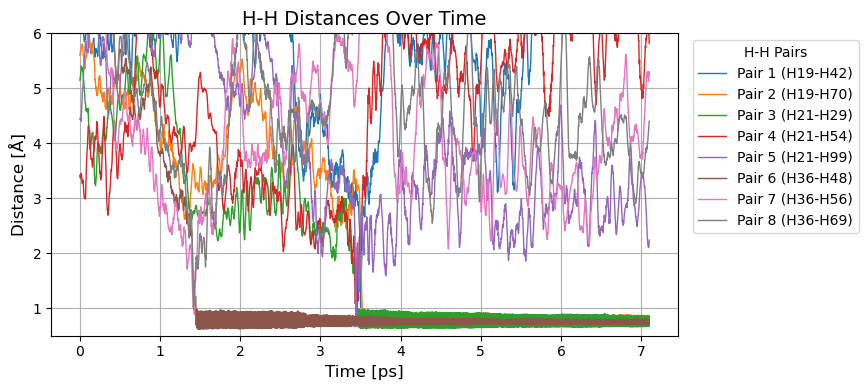


--------CHECHING FORMATION OF H2---------



/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:204: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


Hydrogen pair [19 70] formed molecular hydrogen persistently from 3.52 ps
Hydrogen pair [21 29] formed molecular hydrogen persistently from 3.45 ps
Hydrogen pair [36 48] formed molecular hydrogen persistently from 1.44 ps
Total persistent molecular hydrogen formations: 3
trj_002

--------CHECHING H-H DISTANCES---------

14 potential molecular hydrogens detected.


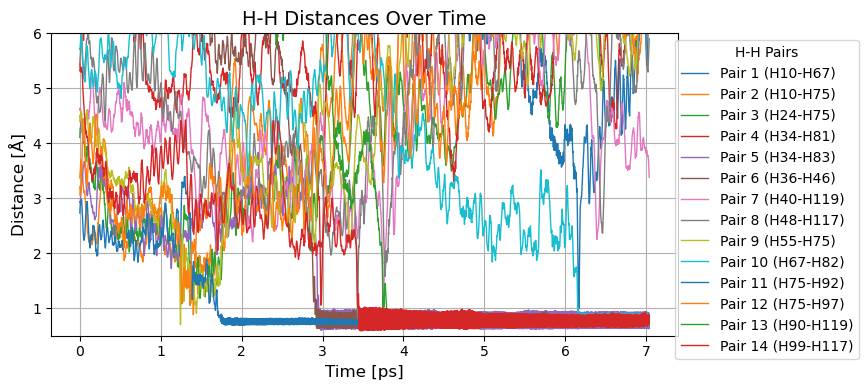


--------CHECHING FORMATION OF H2---------



/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:204: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


Hydrogen pair [34 83] formed molecular hydrogen persistently from 2.95 ps
Hydrogen pair [36 46] formed molecular hydrogen persistently from 2.91 ps
Hydrogen pair [67 82] formed molecular hydrogen persistently from 6.15 ps
Hydrogen pair [75 92] formed molecular hydrogen persistently from 1.7 ps
Hydrogen pair [ 90 119] formed molecular hydrogen persistently from 3.78 ps
Hydrogen pair [ 99 117] formed molecular hydrogen persistently from 3.45 ps
Total persistent molecular hydrogen formations: 6
trj_003

--------CHECHING H-H DISTANCES---------

14 potential molecular hydrogens detected.


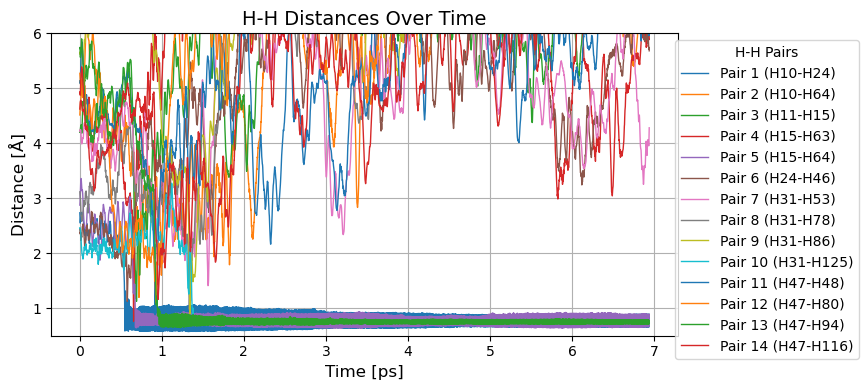


--------CHECHING FORMATION OF H2---------



/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:204: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


Hydrogen pair [10 24] formed molecular hydrogen persistently from 0.56 ps
Hydrogen pair [15 64] formed molecular hydrogen persistently from 0.67 ps
Hydrogen pair [ 31 125] formed molecular hydrogen persistently from 1.36 ps
Hydrogen pair [47 94] formed molecular hydrogen persistently from 0.94 ps
Total persistent molecular hydrogen formations: 4
trj_004

--------CHECHING H-H DISTANCES---------

23 potential molecular hydrogens detected.


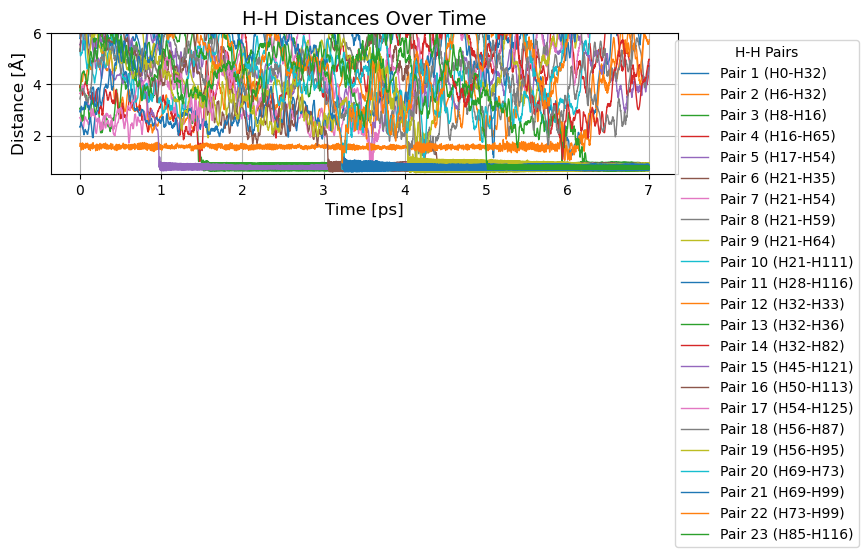


--------CHECHING FORMATION OF H2---------



/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:204: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


Hydrogen pair [ 8 16] formed molecular hydrogen persistently from 1.48 ps
Hydrogen pair [21 35] formed molecular hydrogen persistently from 4.39 ps
Hydrogen pair [32 36] formed molecular hydrogen persistently from 6.23 ps
Hydrogen pair [ 45 121] formed molecular hydrogen persistently from 0.97 ps
Hydrogen pair [ 50 113] formed molecular hydrogen persistently from 3.05 ps
Hydrogen pair [ 54 125] formed molecular hydrogen persistently from 3.6 ps
Hydrogen pair [56 95] formed molecular hydrogen persistently from 4.1 ps
Hydrogen pair [69 99] formed molecular hydrogen persistently from 3.23 ps
Hydrogen pair [ 85 116] formed molecular hydrogen persistently from 5.0 ps
Total persistent molecular hydrogen formations: 9
trj_005

--------CHECHING H-H DISTANCES---------

12 potential molecular hydrogens detected.


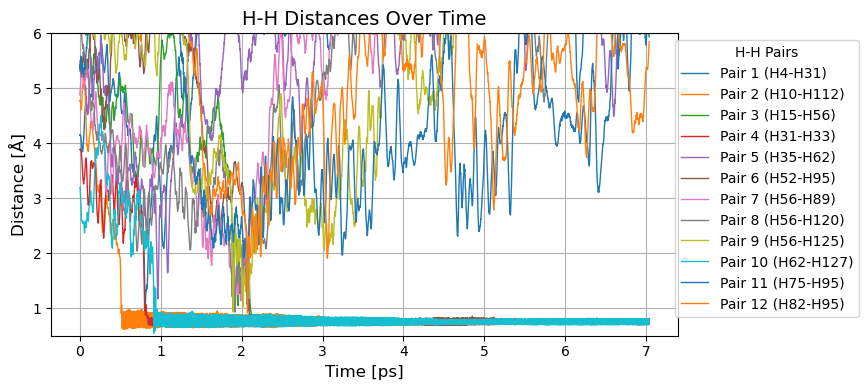


--------CHECHING FORMATION OF H2---------



/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:204: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


Hydrogen pair [ 10 112] formed molecular hydrogen persistently from 0.51 ps
Hydrogen pair [15 56] formed molecular hydrogen persistently from 2.1 ps
Hydrogen pair [31 33] formed molecular hydrogen persistently from 0.8 ps
Hydrogen pair [52 95] formed molecular hydrogen persistently from 2.09 ps
Hydrogen pair [ 62 127] formed molecular hydrogen persistently from 0.94 ps
Total persistent molecular hydrogen formations: 5
trj_006

--------CHECHING H-H DISTANCES---------

19 potential molecular hydrogens detected.


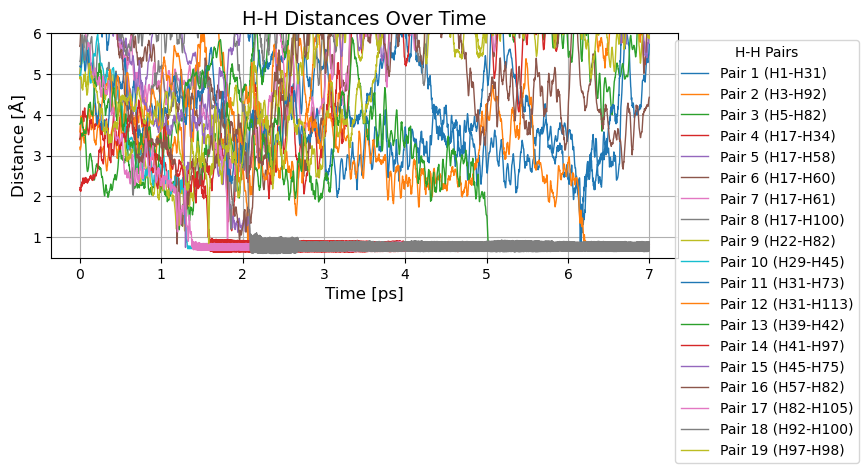


--------CHECHING FORMATION OF H2---------



/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:204: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


Hydrogen pair [17 58] formed molecular hydrogen persistently from 2.08 ps
Hydrogen pair [29 45] formed molecular hydrogen persistently from 1.3 ps
Hydrogen pair [ 31 113] formed molecular hydrogen persistently from 6.19 ps
Hydrogen pair [39 42] formed molecular hydrogen persistently from 5.01 ps
Hydrogen pair [41 97] formed molecular hydrogen persistently from 1.58 ps
Hydrogen pair [ 82 105] formed molecular hydrogen persistently from 1.36 ps
Hydrogen pair [ 92 100] formed molecular hydrogen persistently from 2.09 ps
Total persistent molecular hydrogen formations: 7
trj_007

--------CHECHING H-H DISTANCES---------

7 potential molecular hydrogens detected.


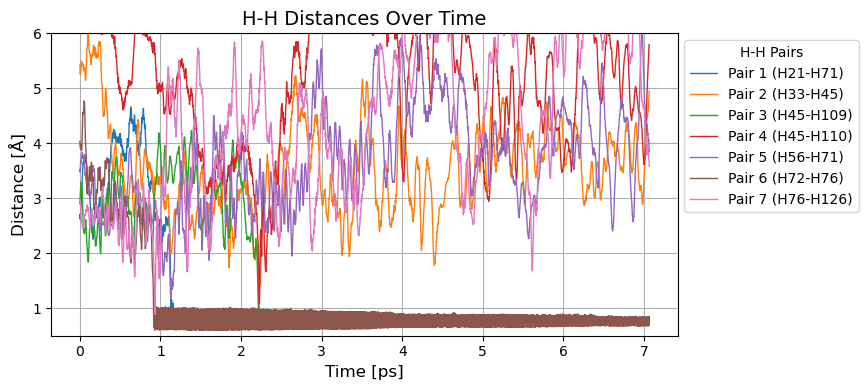


--------CHECHING FORMATION OF H2---------



/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:204: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


Hydrogen pair [21 71] formed molecular hydrogen persistently from 1.13 ps
Hydrogen pair [ 45 109] formed molecular hydrogen persistently from 2.21 ps
Hydrogen pair [72 76] formed molecular hydrogen persistently from 0.92 ps
Total persistent molecular hydrogen formations: 3
trj_008

--------CHECHING H-H DISTANCES---------

13 potential molecular hydrogens detected.


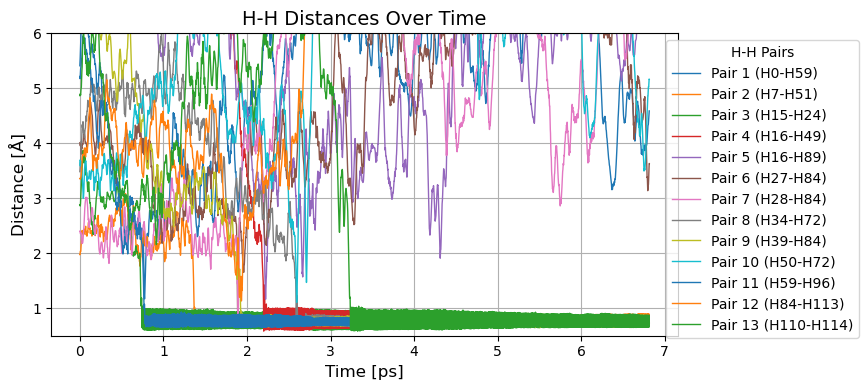


--------CHECHING FORMATION OF H2---------



/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:204: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


Hydrogen pair [ 7 51] formed molecular hydrogen persistently from 1.36 ps
Hydrogen pair [15 24] formed molecular hydrogen persistently from 0.73 ps
Hydrogen pair [16 49] formed molecular hydrogen persistently from 2.21 ps
Hydrogen pair [34 72] formed molecular hydrogen persistently from 2.6 ps
Hydrogen pair [39 84] formed molecular hydrogen persistently from 1.92 ps
Hydrogen pair [59 96] formed molecular hydrogen persistently from 0.76 ps
Hydrogen pair [110 114] formed molecular hydrogen persistently from 3.23 ps
Total persistent molecular hydrogen formations: 7
trj_009

--------CHECHING H-H DISTANCES---------

11 potential molecular hydrogens detected.


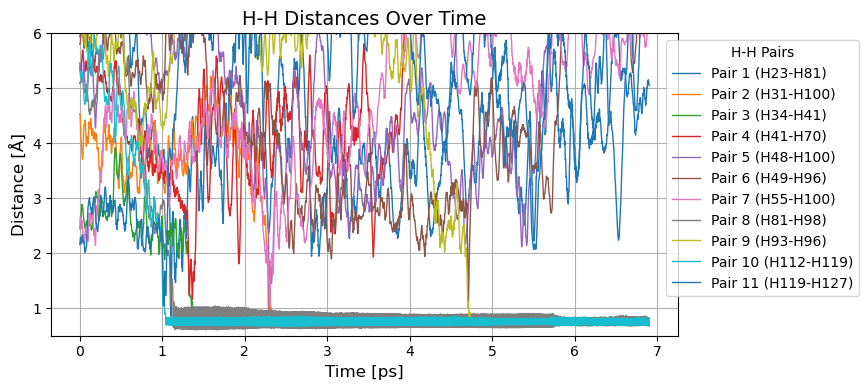


--------CHECHING FORMATION OF H2---------



/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:204: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


Hydrogen pair [ 31 100] formed molecular hydrogen persistently from 2.31 ps
Hydrogen pair [34 41] formed molecular hydrogen persistently from 1.35 ps
Hydrogen pair [81 98] formed molecular hydrogen persistently from 1.13 ps
Hydrogen pair [93 96] formed molecular hydrogen persistently from 4.7 ps
Hydrogen pair [112 119] formed molecular hydrogen persistently from 1.02 ps
Total persistent molecular hydrogen formations: 5
trj_010

--------CHECHING H-H DISTANCES---------

14 potential molecular hydrogens detected.


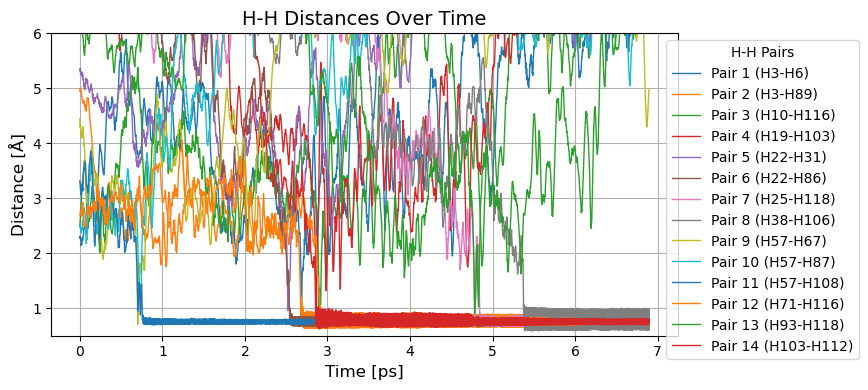


--------CHECHING FORMATION OF H2---------



/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:204: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


Hydrogen pair [ 3 89] formed molecular hydrogen persistently from 2.67 ps
Hydrogen pair [22 86] formed molecular hydrogen persistently from 2.54 ps
Hydrogen pair [ 25 118] formed molecular hydrogen persistently from 4.84 ps
Hydrogen pair [ 38 106] formed molecular hydrogen persistently from 5.37 ps
Hydrogen pair [ 57 108] formed molecular hydrogen persistently from 0.75 ps
Hydrogen pair [ 71 116] formed molecular hydrogen persistently from 2.9 ps
Hydrogen pair [103 112] formed molecular hydrogen persistently from 2.86 ps
Total persistent molecular hydrogen formations: 7


In [9]:
topology_file = fp + '10diel_20Li_64H2O/top.pdb' 
box_size = 13.390


for i in range(1, 11):
    folder_name = f"trj_{i:03}"  
    folder_path = fp + '10diel_20Li_64H2O/' + folder_name  
    print(folder_name)
    trajectory_file = folder_path + '/traj.ALL.xyz' 
    output_indicies = folder_path + 'indices.txt'
    
    
    # print('\n--------CHECHING DISSOCIATIONS OF O-H BONDS---------\n')
    # check_OH_dissociation(trajectory_file, topology_file, box_size, 3.0)
    
    print('\n--------CHECHING H-H DISTANCES---------\n')
    find_HH_distances(trajectory_file, topology_file, box_size)
    
    print('\n--------CHECHING FORMATION OF H2---------\n')
    # track_molecular_hydrogen(trajectory_file, topology_file, box_size, write_indicies=True, output_indicies=output_indicies)
    track_molecular_hydrogen(trajectory_file, topology_file, box_size, write_indicies=False)



--------CHECHING H-H DISTANCES---------

17 potential molecular hydrogens detected.


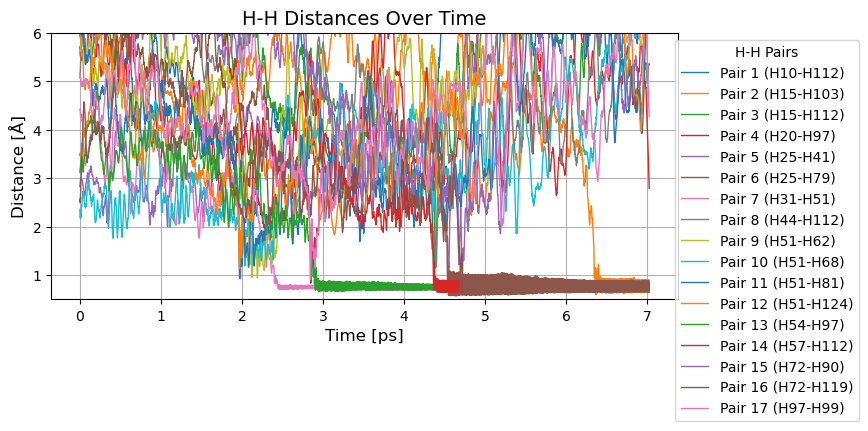


--------CHECHING FORMATION OF H2---------



/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:204: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/tana/.conda/envs/gromacs-test/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


Hydrogen pair [ 15 103] formed molecular hydrogen persistently from 6.4 ps
Hydrogen pair [25 79] formed molecular hydrogen persistently from 4.53 ps
Hydrogen pair [31 51] formed molecular hydrogen persistently from 2.39 ps
Hydrogen pair [54 97] formed molecular hydrogen persistently from 2.87 ps
Hydrogen pair [ 57 112] formed molecular hydrogen persistently from 4.38 ps
Hydrogen pair [ 72 119] formed molecular hydrogen persistently from 4.72 ps
Total persistent molecular hydrogen formations: 6


In [19]:
topology_file = fp + '10diel_20Li_64H2O/top.pdb' 
folder_path = fp + '10diel_20Li_64H2O/trj_037/' 
trajectory_file = folder_path + '/traj.ALL.xyz' 

box_size = 13.390

output_indicies = folder_path + 'indices.txt'

# print('\n--------CHECHING DISSOCIATIONS OF O-H BONDS---------\n')
# check_OH_dissociation(trajectory_file, topology_file, box_size, 3.0)

print('\n--------CHECHING H-H DISTANCES---------\n')
find_HH_distances(trajectory_file, topology_file, box_size)

print('\n--------CHECHING FORMATION OF H2---------\n')
# track_molecular_hydrogen(trajectory_file, topology_file, box_size, write_indicies=True, output_indicies=output_indicies)
track_molecular_hydrogen(trajectory_file, topology_file, box_size, write_indicies=False)




In [13]:
topology_file = fp + '01diel_02Li_64H2O/top.pdb' 
box_size = 12.530


for i in range(1, 51):
    folder_name = f"trj_{i:03}"  
    folder_path = fp + '01diel_02Li_64H2O/' + folder_name  
    print(folder_name)
    trajectory_file = folder_path + '/traj.ALL.xyz' 
    output_indicies = folder_path + 'indices.txt'
    
    
    print('\n--------CHECHING DISSOCIATIONS OF O-H BONDS---------\n')
    check_OH_dissociation(trajectory_file, topology_file, box_size, 3.0)
    
    print('\n--------CHECHING H-H DISTANCES---------\n')
    find_HH_distances(trajectory_file, topology_file, box_size)
    
    print('\n--------CHECHING FORMATION OF H2---------\n')
    # track_molecular_hydrogen(trajectory_file, topology_file, box_size, write_indicies=True, output_indicies=output_indicies)
    track_molecular_hydrogen(trajectory_file, topology_file, box_size, write_indicies=False)


trj_001

--------CHECHING DISSOCIATIONS OF O-H BONDS---------

Total number of dissociated bonds: 0

--------CHECHING H-H DISTANCES---------

0 potential molecular hydrogens detected.

--------CHECHING FORMATION OF H2---------

Total persistent molecular hydrogen formations: 0
trj_002

--------CHECHING DISSOCIATIONS OF O-H BONDS---------

Total number of dissociated bonds: 0

--------CHECHING H-H DISTANCES---------

0 potential molecular hydrogens detected.

--------CHECHING FORMATION OF H2---------

Total persistent molecular hydrogen formations: 0
trj_003

--------CHECHING DISSOCIATIONS OF O-H BONDS---------

Total number of dissociated bonds: 0

--------CHECHING H-H DISTANCES---------

0 potential molecular hydrogens detected.

--------CHECHING FORMATION OF H2---------

Total persistent molecular hydrogen formations: 0
trj_004

--------CHECHING DISSOCIATIONS OF O-H BONDS---------

Total number of dissociated bonds: 0

--------CHECHING H-H DISTANCES---------

0 potential molecular hy

KeyboardInterrupt: 